# Step 2 - Predict Discount Code

## Installation and Setup

In [1]:
%%capture
%pip install pandas matplotlib seaborn scikit-learn xgboost numpy imbalanced-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
import numpy as np
import json
from itertools import cycle  # Not actually used
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings

## 2.A) Data Preperation

#### Drop irrelevant columns

In [ ]:
import pandas as pd

changed_hotels_path = "../data/hotels_data_changed.csv"
df = pd.read_csv(changed_hotels_path)
original_df = df
df = df[['WeekDay', 'Snapshot Date', 'Checkin Date', 'DayDiff', 'Hotel Name', 'Discount Code']] 
df = df.rename(columns={'Discount Code': 'Class'})
df.head()

,WeekDay,Snapshot Date,Checkin Date,DayDiff,Hotel Name,Class
0,Wednesday,2015-07-17,2015-08-12,26,Best Western Plus Seaport Inn Downtown,1
1,Wednesday,2015-07-17,2015-08-19,33,Best Western Plus Seaport Inn Downtown,1
2,Thursday,2015-07-17,2015-08-13,27,The Peninsula New York,1
3,Sunday,2015-07-17,2015-07-26,9,Eventi Hotel a Kimpton Hotel,1
4,Wednesday,2015-07-17,2015-08-12,26,Eventi Hotel a Kimpton Hotel,1


#### Feature Engineering

In [ ]:
def map_days_to_numbers(df: pd.DataFrame) -> pd.DataFrame:
    weekday_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}
    df['WeekDay'] = df['WeekDay'].map(weekday_mapping)
    return df

def map_hotel_names_to_numbers(df: pd.DataFrame) -> pd.DataFrame:
    hotel_mapping = {hotel: i for i, hotel in enumerate(df['Hotel Name'].unique())}
    df['Hotel_Index'] = df['Hotel Name'].map(hotel_mapping)
    df.drop(['Hotel Name'], axis=1, inplace=True)
    return df

def map_date_to_numbers(df: pd.DataFrame, old_coloumn: str, new_coloumn: str) -> pd.DataFrame:
    df[old_coloumn] = pd.to_datetime(df[old_coloumn])
    df[f'{new_coloumn}_Year'] = df[old_coloumn].dt.year
    df[f'{new_coloumn}_Month'] = df[old_coloumn].dt.month
    df[f'{new_coloumn}_Day'] = df[old_coloumn].dt.day
    df.drop([old_coloumn], axis=1, inplace=True)

    return df

In [ ]:
df = map_days_to_numbers(df)
df = map_hotel_names_to_numbers(df)
df = map_date_to_numbers(df, 'Snapshot Date', 'Snapshot')
df = map_date_to_numbers(df, 'Checkin Date', 'Checkin')
df.head()

,WeekDay,DayDiff,Class,Hotel_Index,Snapshot_Year,Snapshot_Month,Snapshot_Day,Checkin_Year,Checkin_Month,Checkin_Day
0,4,26,1,0,2015,7,17,2015,8,12
1,4,33,1,0,2015,7,17,2015,8,19
2,5,27,1,1,2015,7,17,2015,8,13
3,1,9,1,2,2015,7,17,2015,7,26
4,4,26,1,2,2015,7,17,2015,8,12


#### Plot Distributions


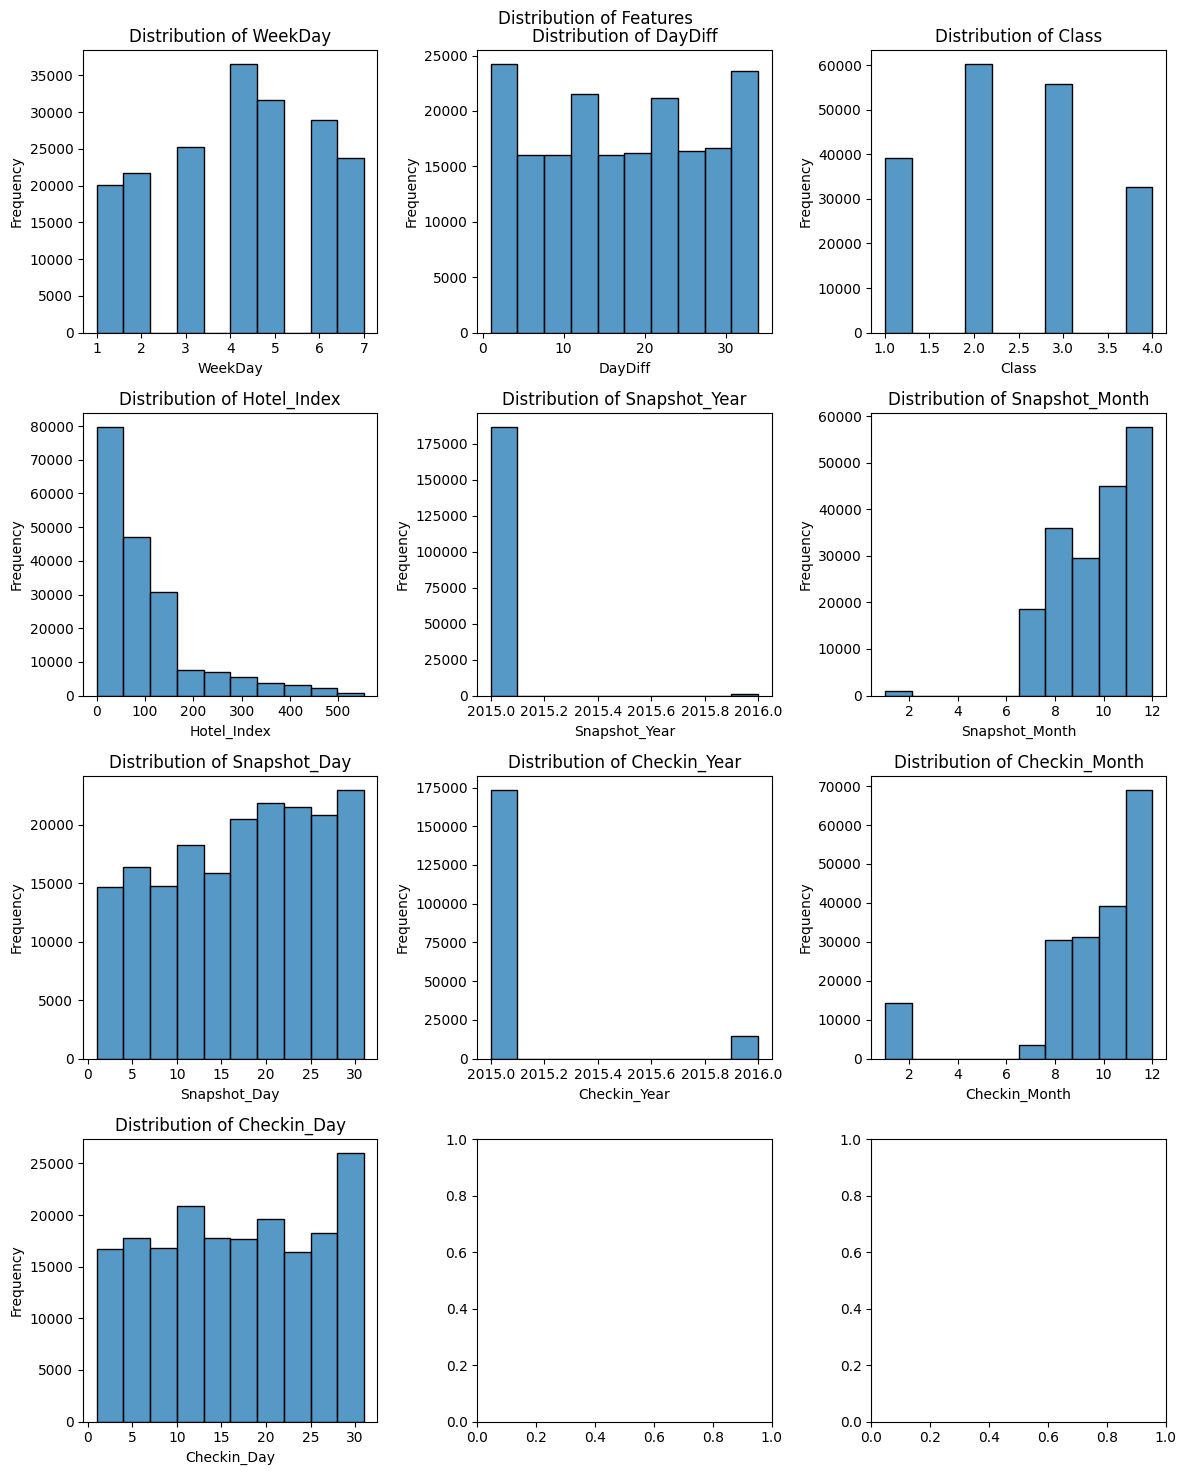

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_features_distribution(df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
    fig.suptitle('Distribution of Features')

    for i, column in enumerate(df.columns):
        row = i // 3  # Calculate row index
        col = i % 3    # Calculate column index
    
        sns.histplot(df[column], bins=10, ax=axes[row, col])
        axes[row, col].set_title(f'Distribution of {column}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_features_distribution(df)

In [ ]:
# Drop Irrelevant Features
# We see that 2016 doesnt have many values and it can manipulte the data.

df = df[df['Checkin_Year'] != 2016]
df = df.drop(columns=['Checkin_Year'])

df = df[df['Snapshot_Year'] != 2016]
df = df.drop(columns=['Snapshot_Year'])

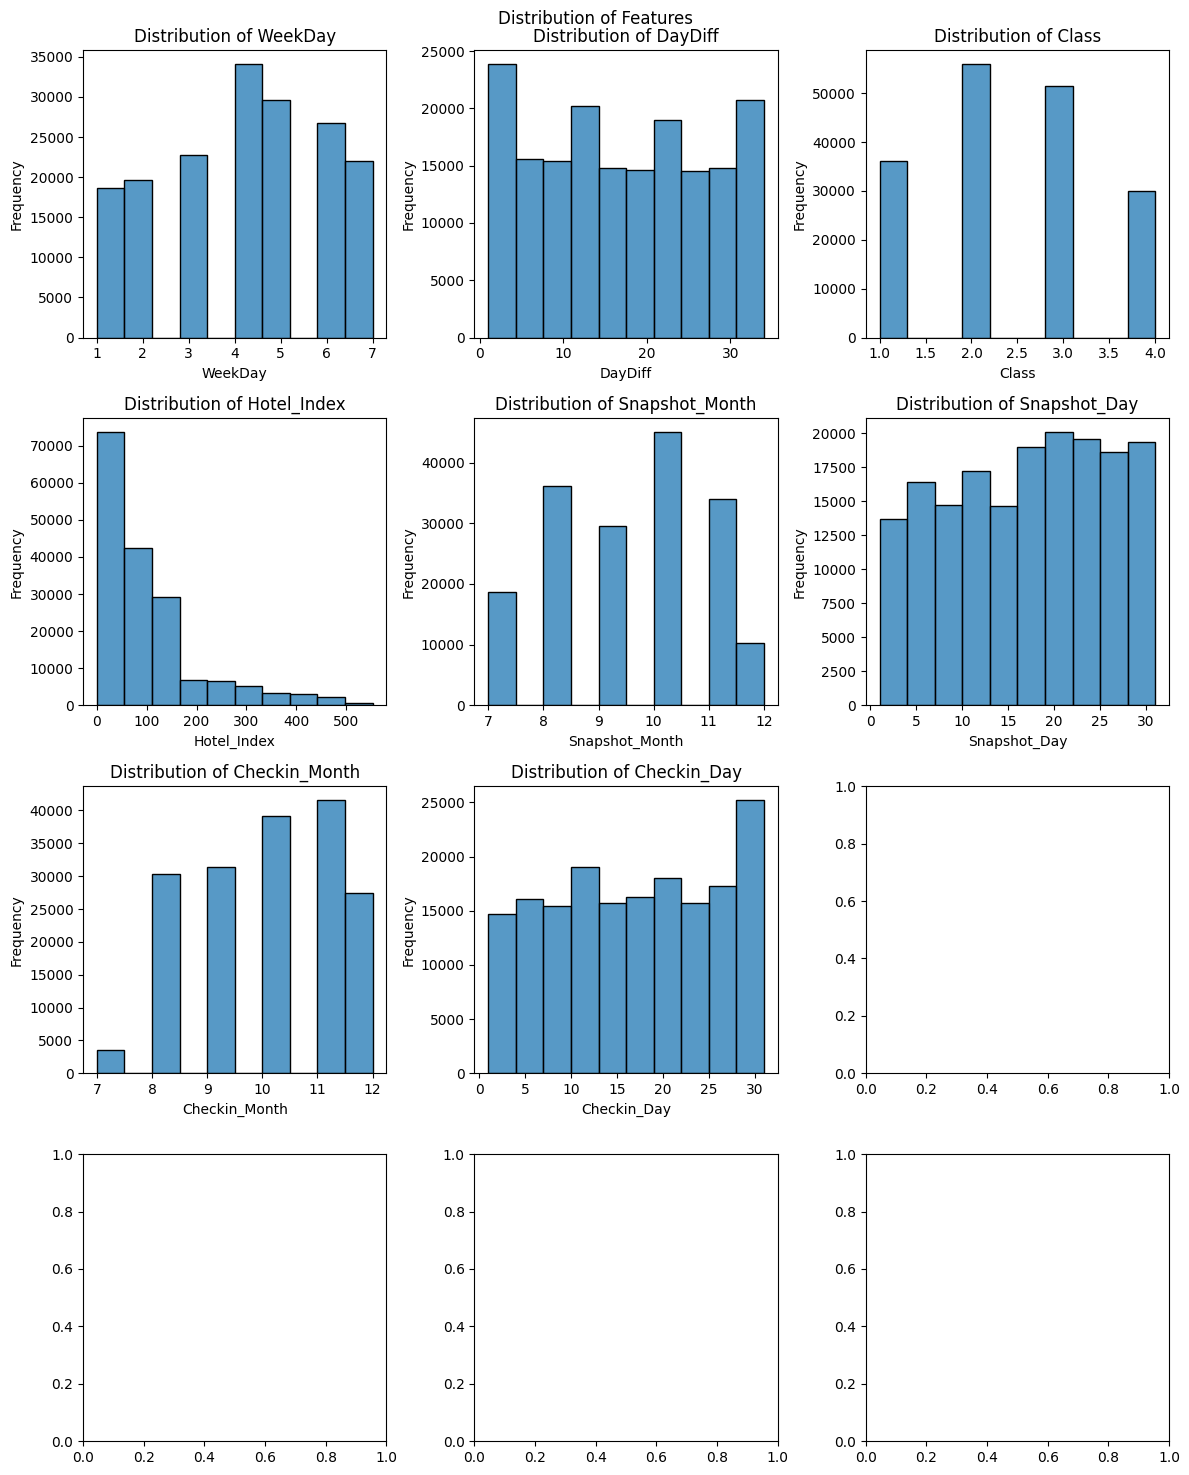

In [ ]:
plot_features_distribution(df)

In [ ]:
# check class imbalance

class_counts = df['Class'].value_counts()
print(class_counts)

Class
2    55972
3    51540
1    36075
4    29953
Name: count, dtype: int64


In [ ]:
df.head()
df.to_csv("../data/hotels_predict_discount.csv", index=False)

## Utils

##### Imports

In [ ]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import json
from itertools import cycle
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
import matplotlib.pyplot as plt

##### Train Test Split

In [ ]:
def change_categrical_feilds(df):
  df['WeekDay'] = df['WeekDay'].astype('category')
  df['Hotel_Index'] = df['Hotel_Index'].astype('category')
  df['Snapshot_Month'] = df['Snapshot_Month'].astype('category')
  df['Checkin_Month'] = df['Checkin_Month'].astype('category')
  df['DayDiff'] = df['DayDiff'].astype('category')
  df['Snapshot_Day'] = df['Snapshot_Day'].astype('category')
  df['Checkin_Day'] = df['Checkin_Day'].astype('category')

  return df


def get_x_y_from_csv():
  hotels_predict_discount_path = "../data/hotels_predict_discount.csv"

  df = pd.read_csv(hotels_predict_discount_path)
  df = change_categrical_feilds(df)

  X = df[['WeekDay', 'DayDiff', 'Hotel_Index', 'Snapshot_Month', 'Snapshot_Day', 'Checkin_Month', 'Checkin_Day']]
  y = df['Class']

  return X, y


def get_train_test():
  X, y = get_x_y_from_csv()
  # XGBost expects [0,1,2,3] instead of [1,2,3,4]
  y = y - 1

  return train_test_split(X, y, test_size=0.2, random_state=42)


def get_smote_train_test():
  X, y = get_x_y_from_csv()
  smote = SMOTE(random_state=42, sampling_strategy='auto')
  X_resampled, y_resampled = smote.fit_resample(X, y)

  return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


def get_undersample_train_test():
  X, y = get_x_y_from_csv()
  rus = RandomUnderSampler(random_state=42)
  X_resampled, y_resampled = rus.fit_resample(X, y)

  return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

##### Evaluation

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print_accuracy(y_train, y_train_pred, y_test, y_test_pred)


def print_accuracy(y_train, y_train_pred, y_test, y_test_pred):
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"  Train Accuracy: {train_accuracy:.2f}")
    print(f"  Test Accuracy: {test_accuracy:.2f}")

In [ ]:
class ModelResults:
    def __init__(self, model, model_name):
        X_train, X_test, y_train, y_test = get_train_test()
        self.model = model
        self.model_name = model_name
        self.X_test = X_test
        self.y_test = np.array(y_test)  # Ensure y_test is a numpy array
        self.classes_ = np.unique(self.y_test)  # Unique classes
        self.n_classes = len(self.classes_)
        
        # Compute predictions
        self.y_pred = self.model.predict(self.X_test)
        self.y_prob = self.model.predict_proba(self.X_test) if hasattr(self.model, 'predict_proba') else None
        
        # Compute all metrics
        self._compute_metrics()
    
    def _compute_metrics(self):
        """Compute all metrics: accuracy, precision, recall, F1, CM, TP, FP, FN, TN, TPR, FPR, AUC-ROC."""
        self.accuracy = accuracy_score(self.y_test, self.y_pred)        
        self.precision = precision_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.recall = recall_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.f1 = f1_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.cm = confusion_matrix(self.y_test, self.y_pred, labels=self.classes_)
        
        # TP, FP, FN, TN per class
        self.tp = np.diag(self.cm)
        self.fp = np.sum(self.cm, axis=0) - self.tp
        self.fn = np.sum(self.cm, axis=1) - self.tp
        self.tn = np.zeros(self.n_classes)
        for i in range(self.n_classes):
            self.tn[i] = self.cm.sum() - (self.cm[i, :].sum() + self.cm[:, i].sum()) + self.cm[i, i]

        # Per-class TPR and FPR (OvA)
        self.tpr = self.tp / (self.tp + self.fn)
        self.fpr = self.fp / (self.fp + self.tn)
        self.tpr = np.where((self.tp + self.fn) == 0, 0, self.tpr)
        self.fpr = np.where((self.fp + self.tn) == 0, 0, self.fpr)
        
        # Micro-average FPR and FNR for overall comparison
        self.tp_micro = np.sum(self.tp)
        self.fp_micro = np.sum(self.fp)
        self.fn_micro = np.sum(self.fn)
        self.tn_micro = np.sum(self.tn)
        self.fpr_micro = self.fp_micro / (self.fp_micro + self.tn_micro) if (self.fp_micro + self.tn_micro) > 0 else 0
        self.fnr_micro = self.fn_micro / (self.fn_micro + self.tp_micro) if (self.fn_micro + self.tp_micro) > 0 else 0

        # Micro-average ROC AUC and store ROC curve data
        y_test_bin = label_binarize(self.y_test, classes=self.classes_)
        self.fpr_roc, self.tpr_roc, _ = roc_curve(y_test_bin.ravel(), self.y_prob.ravel())
        self.roc_auc = auc(self.fpr_roc, self.tpr_roc)
    
    def print_results(self):
        """Print all computed metrics in a readable format."""
        print(f"{self.model_name} Evaluation Results:")
        print(f"Accuracy: {self.accuracy:.4f}")
        print(f"Precision (Macro): {self.precision:.4f}")
        print(f"Recall (Macro): {self.recall:.4f}")
        print(f"F1 Score (Macro): {self.f1:.4f}")
        
        # Confusion Matrix
        print("\nConfusion Matrix:")
        cm_df = pd.DataFrame(self.cm, index=[f"Actual {c+1}" for c in self.classes_],
                            columns=[f"Predicted {c+1}" for c in self.classes_])
        print(cm_df)
        
        # Per-class metrics
        print("\nMetrics per Class:")
        for i in range(self.n_classes):
            print(f"Class {i+1}: True Positive Rate (TPR): {self.tpr[i]:.4f}, False Positive Rate (FPR): {self.fpr[i]:.4f}")
        
        print(f"\nROC AUC: {self.roc_auc:.4f}")
    
    def get_results_dict(self):
        """Return all metrics as a dictionary."""
        results = {
            'accuracy': self.accuracy,
            'precision': self.precision,
            'recall': self.recall,
            'f1': self.f1,
            'confusion_matrix': self.cm,
            'tp': self.tp,
            'fp': self.fp,
            'fn': self.fn,
            'tn': self.tn,
            'tpr': self.tpr,
            'fpr': self.fpr,
            'roc_auc': self.roc_auc
        }
        return results
    
    @staticmethod
    def plot_models_roc(model_results):
        plt.figure(figsize=(8, 6))
        
        # Plot ROC curve for each model
        for results in model_results:
            plt.plot(results.fpr_roc, results.tpr_roc,
                     label=f'{results.model_name} (AUC = {results.roc_auc:.4f})')
        
        # Plot random guess line
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
        
        # Customize the plot
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Micro-average ROC Curves Comparison')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_auc(self):
        plt.figure()
        plt.plot(self.fpr_roc, self.tpr_roc, label=f'ROC Curve (AUC = {self.roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Micro-average ROC Curve')
        plt.legend()
        plt.show()

    @staticmethod
    def compare_models(model_results_list):

        data = []
        for results in model_results_list:
            metrics = {
                'Model': results.model_name,
                'Accuracy': results.accuracy,
                'FPR (Micro)': results.fpr_micro,
                'FNR (Micro)': results.fnr_micro,
                'ROC AUC': results.roc_auc,
                'Precision (Macro)': results.precision,
                'Recall (Macro)': results.recall,
                'F1 (Macro)': results.f1
            }
            data.append(metrics)
        
        df = pd.DataFrame(data)
        
        # Round numeric columns for better readability
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        df[numeric_cols] = df[numeric_cols].round(4)

        display(df)
        

In [ ]:
def model_statistics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=[f'Actual {i+1}' for i in range(cm.shape[0])],
                     columns=[f'Predicted {i+1}' for i in range(cm.shape[1])])
    print(cm_df)

    n_classes = cm.shape[0]

    TP = np.diag(cm)  # True Positives per class
    FP = cm.sum(axis=0) - np.diag(cm)  # False Positives per class
    FN = cm.sum(axis=1) - np.diag(cm)  # False Negatives per class

    TN = np.zeros(n_classes)
    for i in range(n_classes):
        # TN for class i: sum of all elements excluding row i and column i
        TN[i] = cm.sum() - (cm[i, :].sum() + cm[:, i].sum()) + cm[i, i]

    # Calculate TPR (True Positive Rate) and FPR (False Positive Rate) per class
    TPR = TP / (TP + FN)  # Sensitivity or Recall
    FPR = FP / (FP + TN)

    # Handle division by zero
    TPR = np.where((TP + FN) == 0, 0, TPR)
    FPR = np.where((FP + TN) == 0, 0, FPR)

    # Print results
    print("\nMetrics per Class:")
    for i in range(n_classes):
        print(f"Class {i+1}: True Positive Rate (TPR): {TPR[i]:.4f}, False Positive Rate (FPR): {FPR[i]:.4f}")

In [ ]:
def print_class_counts(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)

    y_train_counts = pd.Series(y_train).value_counts()
    y_test_counts = pd.Series(y_test).value_counts()
    unique_classes, y_pred_counts = np.unique(y_pred, return_counts=True)
    y_pred_counts = pd.Series(y_pred_counts, index=unique_classes)

    all_classes = sorted(list(set(y_train.unique()).union(set(y_test.unique())).union(set(y_pred))))

    data = {
        'Class': all_classes,
        'y_train_counts': [y_train_counts.get(c, 0) for c in all_classes],
        'y_test_counts': [y_test_counts.get(c, 0) for c in all_classes],
        'y_pred_counts': [y_pred_counts.get(c, 0) for c in all_classes]
    }

    df_counts = pd.DataFrame(data)
    df_counts['Class'] = df_counts['Class'] + 1

    display(df_counts)

##### Printing Params

In [ ]:
def print_naive_bayes_params(nb):
    params = nb.get_params()

    print(f"  Var smoothing: {params['var_smoothing']}")

In [ ]:
def print_decision_tree_params(dt):
    params = dt.get_params()

    print(f"  Criterion: {params['criterion']}")
    print(f"  Max Depth: {params['max_depth']}")
    print(f"  Depth: {dt.get_depth()}")
    print(f"  Num Leaves: {dt.get_n_leaves()}")
    print(f"  Min Samples Split: {params['min_samples_split']}")
    print(f"  Min Samples Leaf: {params['min_samples_leaf']}")
    print(f"  Max Features: {params['max_features']}")
    print(f"  Max Leaf Nodes: {params['max_leaf_nodes']}")
    print(f"  Min Impurity Decrease: {params['min_impurity_decrease']}")
    print(f"  CCP Alpha: {params['ccp_alpha']}")


In [ ]:
def print_random_forest_params(rf_classifier):
    params = rf_classifier.get_params()

    print(f"  N Estimators: {params['n_estimators']}")
    print(f"  Number of Leaves: {sum(tree.get_n_leaves() for tree in rf_classifier.estimators_)}")
    print(f"  Criterion: {params['criterion']}")
    print(f"  Max Depth: {params['max_depth']}")
    print(f"  Max Features: {params['max_features']}")
    print(f"  Max Leaf Nodes: {params['max_leaf_nodes']}")
    print(f"  Max Samples: {params['max_samples']}")
    print(f"  Min Impurity Decrease: {params['min_impurity_decrease']}")
    print(f"  Min Samples Leaf: {params['min_samples_leaf']}")
    print(f"  Min Samples Split: {params['min_samples_split']}")
    print(f"  Min Weight Fraction Leaf: {params['min_weight_fraction_leaf']}")
    print(f"  Parameters: {params}")


In [ ]:
def print_xgb_params(xgb):
  booster = xgb.get_booster()

  config_str = booster.save_config()
  config_dict = json.loads(config_str)

  learner_params = config_dict['learner']

  print(f" max_depth: {learner_params['gradient_booster']['tree_train_param']['max_depth']}")
  print(f" learning_rate: {learner_params['gradient_booster']['tree_train_param']['learning_rate']:.3}")

## 2.B) Algorithms

Implement and evaluate the following five algorithms: Random Forest, Decision Tree, Naïve Bayes, XGBoost, and a simple Random classifier.
For each algorithm, you need to experiment with different parameter settings to find the optimal combination that yields the best performance. 
Explanation of how each chosen parameter affects the algorithm's performance. 

### Naive Bayes

#### Default Params

In [ ]:
X_train, X_test, y_train, y_test = get_train_test()
nb_categorial = CategoricalNB()
nb_categorial.fit(X_train, y_train)

evaluate_model(nb_categorial, X_train, X_test, y_train, y_test)

  Train Accuracy: 0.37
  Test Accuracy: 0.36


In [ ]:
model_statistics(nb_categorial, X_test, y_test)

Accuracy: 0.3600
Precision (Macro): 0.3417
Recall (Macro): 0.3219
F1 Score (Macro): 0.3315
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         1810         3029         1867          424
Actual 2         1582         5592         3575          484
Actual 3         1123         4195         4468          568
Actual 4         1015         2063         2288          625

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.2539, False Positive Rate (FPR): 0.1349
Class 2: True Positive Rate (TPR): 0.4978, False Positive Rate (FPR): 0.3956
Class 3: True Positive Rate (TPR): 0.4315, False Positive Rate (FPR): 0.3174
Class 4: True Positive Rate (TPR): 0.1043, False Positive Rate (FPR): 0.0514


In [ ]:
print_class_counts(nb_categorial, X_test, y_test, y_train)

,Class,y_train_counts,y_test_counts,y_pred_counts
0,1,28945,7130,5530
1,2,44739,11233,14879
2,3,41186,10354,12198
3,4,23962,5991,2101


#### Hyperparaeters tuning

Last model (with default prior=true) gave class 4 little percentage.
try to add for misrepresented class with smote

In [ ]:
X_train, X_test, y_train, y_test = get_smote_train_test()

In [ ]:
X_train, X_test, y_train, y_test = get_smote_train_test()
nb_categorial_smote = CategoricalNB(fit_prior=False)
nb_categorial_smote.fit(X_train, y_train)

model_statistics(nb_categorial_smote, X_test, y_test)

d:\application\anaconda\envs\DS-101-Final\Lib\site-packages\pandas\core\arrays\base.py:568: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


Accuracy: 0.3540
Precision (Macro): 0.3548
Recall (Macro): 0.3534
F1 Score (Macro): 0.3541
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         4507         2101         1337         3262
Actual 2         2988         3149         2350         2674
Actual 3         2401         2173         3032         3472
Actual 4         3073         1281         1814         5164

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.4022, False Positive Rate (FPR): 0.2521
Class 2: True Positive Rate (TPR): 0.2821, False Positive Rate (FPR): 0.1652
Class 3: True Positive Rate (TPR): 0.2737, False Positive Rate (FPR): 0.1632
Class 4: True Positive Rate (TPR): 0.4557, False Positive Rate (FPR): 0.2813


no class imbalance but less accurate

class sklearn.naive_bayes.CategoricalNB(*, alpha=1.0, force_alpha=True, fit_prior=True, class_prior=None, min_categories=None)

grid_search for alpha(var_smoothing) wasnt better

In [ ]:
nb_best_model = nb_categorial

### Decision Tree

#### Default Params

In [ ]:
X_train, X_test, y_train, y_test = get_train_test()

dt_classifier = DecisionTreeClassifier(random_state=42) 
dt_classifier.fit(X_train, y_train)

evaluate_model(dt_classifier, X_train, X_test, y_train, y_test)
print_decision_tree_params(dt_classifier)

  Train Accuracy: 0.64
  Test Accuracy: 0.27
  Criterion: gini
  Max Depth: None
  Depth: 44
  Num Leaves: 56572
  Min Samples Split: 2
  Min Samples Leaf: 1
  Max Features: None
  Max Leaf Nodes: None
  Min Impurity Decrease: 0.0
  CCP Alpha: 0.0


In [ ]:
model_statistics(dt_classifier, X_test, y_test)

Accuracy: 0.2748
Precision (Macro): 0.2917
Recall (Macro): 0.2728
F1 Score (Macro): 0.2820
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         2351         3578          855          346
Actual 2         4078         3299         3324          532
Actual 3         2633         3736         2577         1408
Actual 4         1553         1573         1553         1312

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.3297, False Positive Rate (FPR): 0.2997
Class 2: True Positive Rate (TPR): 0.2937, False Positive Rate (FPR): 0.3786
Class 3: True Positive Rate (TPR): 0.2489, False Positive Rate (FPR): 0.2354
Class 4: True Positive Rate (TPR): 0.2190, False Positive Rate (FPR): 0.0796


#### HyperParameter Tuning


DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)[source]

**criterion: ['gini', 'entropy']** Gini and Entropy are two different ways to calculate the information gain. They can result in different tree structures.

splitter - default evaluates all features and chooses the split that maximizes the chosen criterion ("gini" or "entropy").

**max_depth: [3, 10, 20, 30]** last tree was 44 which is too much for 7 features..

**min_samples_split: [2, 5, 10]** Increasing min_samples_split forces the tree to make splits only when there are enough samples, preventing it from creating overly specific branches that might fit noise in the training data.

**min_samples_leaf: [1, 2, 5]** increasing min_samples_leaf forces the tree to create larger, more generalized leaf nodes, which can improve performance on unseen data.

min_weight_fraction_leaf -  minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.

**max_features: [None, 5, 3]** None = all. log(7) or sqrt(7) will be 3, and i chose 1 in between. Limiting max_features can sometimes improve performance by reducing overfitting

**max_leaf_nodes': [None, 2000, 3500, 5000, 6500]** tree had 56,000 leaf noedes which was too much.

**min_impurity_decrease': [0.0, 0.1, 0.2]** sets a minimum threshold for the impurity reduction. A split will only occur if the impurity reduction is greater than or equal to this threshold. It helps prevent the tree from making splits that result in very small impurity reductions, which might indicate overfitting.  

class_weight=None

**ccp_alpha': [0.0, 0.1, 0.2]** cost-complexity pruning in decision trees.
It controls the trade-off between the size of the tree and its accuracy on the training data.   
Higher ccp_alpha values lead to more pruning, resulting in smaller trees
<img src="../images/ccp_alpha.png" width=400 height=300>

monotonic_cst=None Indicates the monotonicity constraint to enforce on each feature.


In [ ]:
X_train, X_test, y_train, y_test = get_train_test()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 5, 3],
    'max_leaf_nodes': [None, 2000, 3500, 5000, 6500],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

dt_grid_1 = grid_search.best_estimator_

evaluate_model(dt_grid_1, X_train, X_test, y_train, y_test)
print_decision_tree_params(dt_grid_1)

  Train Accuracy: 0.50
  Test Accuracy: 0.42
  Criterion: gini
  Max Depth: 30
  Depth: 27
  Num Leaves: 3500
  Min Samples Split: 2
  Min Samples Leaf: 2
  Max Features: None
  Max Leaf Nodes: 3500
  Min Impurity Decrease: 0.0
  CCP Alpha: 0.0


156 minutes vs 16 seconds same accuracy.
only needed to add max leaf nodes

In [ ]:
X_train, X_test, y_train, y_test = get_train_test()

param_grid = {
    'max_leaf_nodes': [None, 2000, 3500, 5000, 6500],
}

grid_search_2 = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)

grid_search_2.fit(X_train, y_train)

dt_grid_2 = grid_search_2.best_estimator_

evaluate_model(dt_grid_2, X_train, X_test, y_train, y_test)
print_decision_tree_params(dt_grid_2)

  Train Accuracy: 0.50
  Test Accuracy: 0.42
  Criterion: gini
  Max Depth: None
  Depth: 27
  Num Leaves: 3500
  Min Samples Split: 2
  Min Samples Leaf: 1
  Max Features: None
  Max Leaf Nodes: 3500
  Min Impurity Decrease: 0.0
  CCP Alpha: 0.0


In [ ]:
model_statistics(dt_grid_2, X_test, y_test)

Accuracy: 0.4216
Precision (Macro): 0.4222
Recall (Macro): 0.4052
F1 Score (Macro): 0.4135
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         3031         2295         1346          458
Actual 2         2176         5394         3004          659
Actual 3         1330         3384         4560         1080
Actual 4          739         1583         2020         1649

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.4251, False Positive Rate (FPR): 0.1539
Class 2: True Positive Rate (TPR): 0.4802, False Positive Rate (FPR): 0.3094
Class 3: True Positive Rate (TPR): 0.4404, False Positive Rate (FPR): 0.2616
Class 4: True Positive Rate (TPR): 0.2752, False Positive Rate (FPR): 0.0765


In [ ]:
dt_best_model = dt_grid_2

### Random forest

#### Default Parameters

In [ ]:
X_train, X_test, y_train, y_test = get_train_test()

rf_classifier = RandomForestClassifier() 

rf_classifier.fit(X_train, y_train)

evaluate_model(rf_classifier, X_train, X_test, y_train, y_test)
print_random_forest_params(rf_classifier)

  Train Accuracy: 0.64
  Test Accuracy: 0.24
  N Estimators: 100
  Number of Leaves: 5158701
  Criterion: gini
  Max Depth: None
  Max Features: sqrt
  Max Leaf Nodes: None
  Max Samples: None
  Min Impurity Decrease: 0.0
  Min Samples Leaf: 1
  Min Samples Split: 2
  Min Weight Fraction Leaf: 0.0
  Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
model_statistics(rf_classifier, X_test, y_test)

Accuracy: 0.2369
Precision (Macro): 0.2325
Recall (Macro): 0.2309
F1 Score (Macro): 0.2317
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         1680         3030         1614          806
Actual 2         2863         2951         4054         1365
Actual 3         1577         4067         2475         2235
Actual 4          900         1536         2439         1116

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.2356, False Positive Rate (FPR): 0.1936
Class 2: True Positive Rate (TPR): 0.2627, False Positive Rate (FPR): 0.3678
Class 3: True Positive Rate (TPR): 0.2390, False Positive Rate (FPR): 0.3329
Class 4: True Positive Rate (TPR): 0.1863, False Positive Rate (FPR): 0.1534


#### HyperParameter Tuninig

RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)[source]


In [ ]:
param_grid = {
     'max_depth': [None, 3, 7, 15],  # Maximum depth of the tree
}

rf = RandomForestClassifier(random_state=42) #Setting a random state for reproducibility

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

rf_grid = grid_search.best_estimator_
evaluate_model(rf_grid, X_train, X_test, y_train, y_test)
print_random_forest_params(rf_grid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Train Accuracy: 0.36
  Test Accuracy: 0.36
  N Estimators: 100
  Number of Leaves: 12446
  Criterion: gini
  Max Depth: 7
  Max Features: sqrt
  Max Leaf Nodes: None
  Max Samples: None
  Min Impurity Decrease: 0.0
  Min Samples Leaf: 1
  Min Samples Split: 2
  Min Weight Fraction Leaf: 0.0
  Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
model_statistics(rf_grid, X_test, y_test)

Accuracy: 0.3565
Precision (Macro): 0.2803
Recall (Macro): 0.2937
F1 Score (Macro): 0.2868
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1          798         4406         1926            0
Actual 2          597         7284         3352            0
Actual 3          277         5787         4290            0
Actual 4          252         3190         2549            0

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.1119, False Positive Rate (FPR): 0.0408
Class 2: True Positive Rate (TPR): 0.6484, False Positive Rate (FPR): 0.5701
Class 3: True Positive Rate (TPR): 0.4143, False Positive Rate (FPR): 0.3214
Class 4: True Positive Rate (TPR): 0.0000, False Positive Rate (FPR): 0.0000


d:\application\anaconda\envs\DS-101-Final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


when we capped the depth of the tree it didnt learn class 4.
lets try it with smote

In [ ]:
X_train, X_test, y_train, y_test = get_smote_train_test()

rf_smote_classifier = RandomForestClassifier(max_depth=7) 

rf_classifier.fit(X_train, y_train)

model_statistics(rf_classifier, X_test, y_test)

d:\application\anaconda\envs\DS-101-Final\Lib\site-packages\pandas\core\arrays\base.py:568: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


Accuracy: 0.3586
Precision (Macro): 0.3541
Recall (Macro): 0.3577
F1 Score (Macro): 0.3559
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         4895         2897         1811         1604
Actual 2         3142         2699         3620         1700
Actual 3         1937         3546         2774         2821
Actual 4         1590         1410         2644         5688

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.4368, False Positive Rate (FPR): 0.1987
Class 2: True Positive Rate (TPR): 0.2418, False Positive Rate (FPR): 0.2336
Class 3: True Positive Rate (TPR): 0.2504, False Positive Rate (FPR): 0.2396
Class 4: True Positive Rate (TPR): 0.5019, False Positive Rate (FPR): 0.1831


same problem. lets try addidng weights for each class

In [ ]:
X_train, X_test, y_train, y_test = get_train_test()
unique_classes, class_counts = np.unique(y_train, return_counts=True)
total_instances = class_counts.sum()
class_weights = {cls: total_instances / (len(unique_classes) * count) for cls, count in zip(unique_classes, class_counts)}
print("Class weights:", class_weights)

Class weights: {0: 1.1991017446882017, 1: 0.7757884619683051, 2: 0.8427135434370903, 3: 1.4484600617644603}


In [ ]:
rf_weighted_classifier = RandomForestClassifier(class_weight=class_weights) 

rf_classifier.fit(X_train, y_train)

model_statistics(rf_classifier, X_test, y_test)

Accuracy: 0.2318
Precision (Macro): 0.2275
Recall (Macro): 0.2258
F1 Score (Macro): 0.2267
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         1650         3003         1694          783
Actual 2         2914         2909         4038         1372
Actual 3         1569         4158         2404         2223
Actual 4          893         1564         2452         1082

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.2314, False Positive Rate (FPR): 0.1949
Class 2: True Positive Rate (TPR): 0.2590, False Positive Rate (FPR): 0.3717
Class 3: True Positive Rate (TPR): 0.2322, False Positive Rate (FPR): 0.3360
Class 4: True Positive Rate (TPR): 0.1806, False Positive Rate (FPR): 0.1525


didnt go well. so best classifier was the one that didnt classify 4 at all ..

In [ ]:
rf_best_model = rf_grid

### XGBoost

#### Default Params

In [ ]:
X_train, X_test, y_train, y_test = get_train_test()

xgb_model = XGBClassifier(objective='multi:softprob', num_class=4, random_state=42, enable_categorical=True) # multi class returns propabilites
xgb_model.fit(X_train, y_train)

evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
print_xgb_params(xgb_model)

  Train Accuracy: 0.55
  Test Accuracy: 0.38
 max_depth: 6
 learning_rate: 0.3


In [ ]:
model_statistics(xgb_model, X_test, y_test)

Accuracy: 0.3753
Precision (Macro): 0.3713
Recall (Macro): 0.3610
F1 Score (Macro): 0.3661
          Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 1         2509         2580         1426          615
Actual 2         2192         4842         3306          893
Actual 3         1169         3590         4065         1530
Actual 4          716         1553         2113         1609

Metrics per Class:
Class 1: True Positive Rate (TPR): 0.3519, False Positive Rate (FPR): 0.1478
Class 2: True Positive Rate (TPR): 0.4311, False Positive Rate (FPR): 0.3290
Class 3: True Positive Rate (TPR): 0.3926, False Positive Rate (FPR): 0.2811
Class 4: True Positive Rate (TPR): 0.2686, False Positive Rate (FPR): 0.1058


#### HyperParameter Tuninig

XGBClassifier( n_estimators: int = 1, *, booster: typing.Literal["gbtree", "dart"] = "gbtree", dart_normalized_type: typing.Literal["tree", "forest"] = "tree", tree_method: typing.Literal["auto", "exact", "approx", "hist"] = "auto", min_tree_child_weight: int = 1, colsample_bytree: float = 1.0, colsample_bylevel: float = 1.0, colsample_bynode: float = 1.0, gamma: float = 0.0, max_depth: int = 6, subsample: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 1.0, learning_rate: float = 0.3, max_iterations: int = 20, tol: float = 0.01, enable_global_explain: bool = False, xgboost_version: typing.Literal["0.9", "1.1"] = "0.9" )

n_estimators - num_parallel_tree

booster - gbtree (gradient boosting with trees) is generally a stronger choice for low-dimensional data. no need for  dart (Dropout Additive Regression Trees) and much slower

tree_method - (Tree Construction Algorithms) didnt look better.

min_child_weight: minimum sum of instance weight (hessian) needed in a child. This can be used to control the complexity of the decision tree by preventing the creation of too small leaves. tried [1, 5, 10] and didnt improve.

colsample_bytree: percentage of columns used for each tree construction. Lowering this value can prevent overfitting by training on a subset of the features. we dont have overfitting, and when we trained 1 tree to take all features was best.
same for by_tree and by_node

gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization. 

**max_depth: [4, 6, 8]** Deeper trees can capture more complex patterns in the data, but may also lead to overfitting.

subsample: percentage of rows used for each tree construction. Lowering this value can prevent overfitting by training on a smaller subset of the data.

reg_alpha	- L1 regularization term on weights (xgb's alpha). Default to 0.0.

reg_lambda- L2 regularization term on weights (xgb's lambda). Default to 1.0.

**learning_rate: [0.1, 0.3, 0.4]** deafulat 0.3

 max_iterations - would be redundant because early stopping already determines the optimal number of boosting rounds based on data and other hyperparameters.

 tol - Minimum relative loss improvement necessary to continue training


In [ ]:
X_train, X_test, y_train, y_test = get_train_test()

xgb_model = XGBClassifier(objective='multi:softprob', num_class=4, random_state=42, enable_categorical=True)

param_grid = {
    'max_depth': [4, 6, 8, 12],
    'learning_rate': [0.05, 0.08, 0.1, 0.3, 0.4],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

xgb_best_model = grid_search.best_estimator_
evaluate_model(xgb_best_model, X_train, X_test, y_train, y_test)
print_xgb_params(xgb_best_model)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
  Train Accuracy: 0.49
  Test Accuracy: 0.41
 max_depth: 4
 learning_rate: 0.3


## 2.C) Results Overview

| Model | Accuracy |
|---|---|
| Naive Bayes | 0.35 |
| Decision Tree | 0.42 |
| Random Forest | 0.37 |
| XGBoost | 0.42 |

**Observations:**
* **Random Forest:** The fact that only a single decision tree surpasssed random forest and XGBoost was surprising. the random forest was not able to identify class 4 - it had a problem with imbalance and when we tried fixing the imbalance it didnt help.
* **Naive Bayes:** Naive Bayes had the lowest accuracy at 0.35. This might indicate that the assumption of feature independence made by Naive Bayes doesn't hold well for your data.


We couldnt surpass 42%. <br>

## 2.D) Most Effective Parameters

The most effective parameters as we explained before were max_depth - because the tree grew too large becuase we have a lot of data. also max_leaf_nodes which capped the tree size did a good job - accuracy went up by 15% and reduced overfitting.

## 2.E) Statistical Anylsis

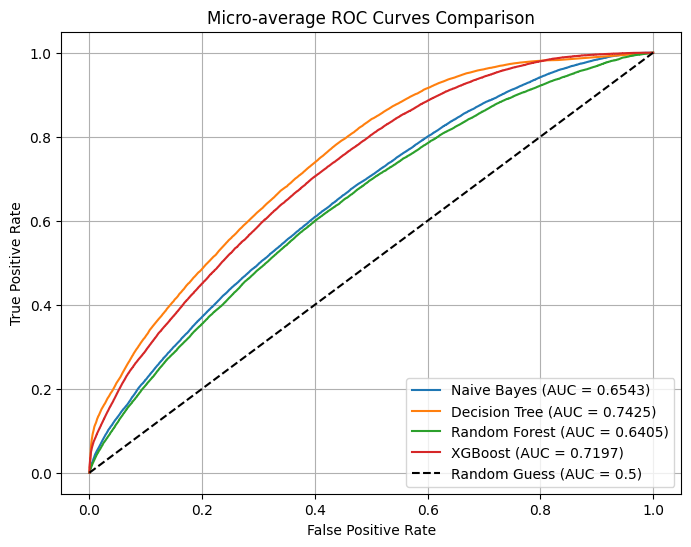

In [ ]:
mode_results = [ModelResults(nb_best_model, 'Naive Bayes'),
                ModelResults(dt_best_model, 'Decision Tree'),
                ModelResults(rf_best_model, 'Random Forest'),
                ModelResults(xgb_best_model, 'XGBoost')]
ModelResults.plot_models_roc(mode_results)

In [ ]:
ModelResults.compare_models(mode_results)

,Model,Accuracy,FPR (Micro),FNR (Micro),ROC AUC,Precision (Macro),Recall (Macro),F1 (Macro)
0,Naive Bayes,0.3600,0.2133,0.6400,0.6543,0.3417,0.3219,0.3162
1,Decision Tree,0.4220,0.1927,0.5780,0.7425,0.4227,0.4052,0.4092
2,Random Forest,0.3565,0.2145,0.6435,0.6405,0.2803,0.2937,0.2537
3,XGBoost,0.4055,0.1982,0.5945,0.7197,0.4055,0.3835,0.3888


To Compare between the models accuracy is enough